In [7]:
#Import packages
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import s3fs
import geocat.comp
from datetime import datetime
import dask
import zarr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import netCDF4
import os
import proplot as pplt
import warnings
from numpy import meshgrid, deg2rad, gradient, cos, sin
from xarray import DataArray
from scipy import stats
from scipy.interpolate import griddata
warnings.filterwarnings('ignore')

In [8]:
#Specify model names
modelNames=['CESM2','CESM2-FV2','CESM2-WACCM','CESM2-WACCM-FV2','CMCC-CM2-SR5','CanESM5',
'E3SM-1-1','E3SM-1-1-ECA','FGOALS-g3','GFDL-CM4','GFDL-ESM4','GISS-E2-1-H','SAM0-UNICON'] #'MIROC-ES2L' file missing, 'MPI-ESM1-2-HR'has bad data??

othermodels=['MIROC6','MPI-ESM-1-2-HAM','MRI-ESM2-0'] #these models have a different time format, not sure how to include them

In [9]:
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

precstdlist=[]
crestdlist=[]

for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cres=data['cres']
    
    cres=cres[1548:,:,:]
    datetimeindex=cres.indexes['time'].to_datetimeindex()
    cres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select november index
    month_idxs=cres.groupby('time.month').groups
    november_idxs=month_idxs[11]
    test_idxs=month_idxs[11]
    cres_november=cres.isel(time=november_idxs)
    prec_november=precip.isel(time=november_idxs)
    

    

    SAMlat=cres_november.lat
    SAMlon=cres_november.lon

    #Detrend data sets
    time=cres_november.time
    cres_november=cres_november.to_numpy()
    time=time.to_numpy()
    prec_november=prec_november.to_numpy()

    time=time.astype(int)/10**9

    cres_november=detrend(cres_november,time)
    cres_november=xr.DataArray(cres_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=detrend(prec_november,time)
    prec_november=xr.DataArray(prec_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=xr.where(prec_november<0,0,prec_november) #apply Non-negative precipitation physical constraint

    #Select only region we want
    prec_november=prec_november.sel(lon=slice(225,250))
    prec_november=prec_november.sel(lat=slice(40,60))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_november*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 
    
    #Calculate standard deviation of precipitation index, gives a single value for each model
    mystd=prec_index.std()
    

    precstdlist.append(mystd) #append list of precipitation standard deviations for each model
    
    #Calculate model CRE standard deviation, gives a std for each grid cell 
    crestd=cres_november.std(axis=0)
    
    crestd=crestd.to_numpy()
    
    #Regrid all models to a common grid
    X, Y =np.meshgrid(lons,lats)
    lat1=np.linspace(90,-90,360)
    lon1=np.linspace(0,360,720)
    XI,YI=np.meshgrid(lon1,lat1)
    
    regridcrestd=griddata((X.flatten(),Y.flatten()), crestd.flatten(), (XI,YI), method='nearest')
    
    crestdlist.append(regridcrestd) #append list of cres standard deviations for each model
    crestdstack=np.stack(crestdlist,axis=0) #stack the lists to obtain the correct dimensions
    

prstd=xr.DataArray(data=precstdlist,coords={'models':np.arange(1,len(modelNames)+1)}) 

condition=np.mean(prstd)+2*np.std(prstd) #calculate the condition to be used in regression calculation

crestdfinal=xr.DataArray(data=crestdstack,coords={'models':np.arange(1,len(modelNames)+1),'lat':lat1,'lon':lon1})


prfinal,crestdfinal = xr.broadcast(prstd,crestdfinal) #broadcast prstd array to fill array to allow regression to be executed


#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])

#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    prfinal,crestdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )



intercepts=xr.apply_ufunc(ints,
                    prfinal,crestdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )

cresregression=slopes*condition+intercepts


In [10]:
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

precstdlist=[]
cresSurftdlist=[]

for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cresSurf=data['cresSurf']
    
    cresSurf=cresSurf[1548:,:,:]
    datetimeindex=cresSurf.indexes['time'].to_datetimeindex()
    cresSurf['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select november index
    month_idxs=cresSurf.groupby('time.month').groups
    november_idxs=month_idxs[11]
    test_idxs=month_idxs[11]
    cresSurf_november=cresSurf.isel(time=november_idxs)
    prec_november=precip.isel(time=november_idxs)
    

    SAMlat=cresSurf_november.lat
    SAMlon=cresSurf_november.lon

    #Detrend data sets
    time=cresSurf_november.time
    cresSurf_november=cresSurf_november.to_numpy()
    time=time.to_numpy()
    prec_november=prec_november.to_numpy()

    time=time.astype(int)/10**9

    cresSurf_november=detrend(cresSurf_november,time)
    cresSurf_november=xr.DataArray(cresSurf_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=detrend(prec_november,time)
    prec_november=xr.DataArray(prec_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=xr.where(prec_november<0,0,prec_november) #apply Non-negative precipitation physical constraint

    
    #Select only region we want
    prec_november=prec_november.sel(lon=slice(225,250))
    prec_november=prec_november.sel(lat=slice(40,60))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_november*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 
    
    #Calculate standard deviation of precipitation index, gives a single value for each model
    mystd=prec_index.std()
    

    precstdlist.append(mystd) #append list of precipitation standard deviations for each model
    
    #Calculate model CRE standard deviation, gives a std for each grid cell 
    cresSurftd=cresSurf_november.std(axis=0)
    
    cresSurftd=cresSurftd.to_numpy()
    
    #Regrid all models to a common grid
    X, Y =np.meshgrid(lons,lats)
    lat1=np.linspace(90,-90,360)
    lon1=np.linspace(0,360,720)
    XI,YI=np.meshgrid(lon1,lat1)
    
    regridcresSurftd=griddata((X.flatten(),Y.flatten()), cresSurftd.flatten(), (XI,YI), method='nearest')
    cresSurftdlist.append(regridcresSurftd) #append list of cresSurf standard deviations for each model
    
    cresSurftdstack=np.stack(cresSurftdlist,axis=0) #stack the lists to obtain the correct dimensions
    

prstd=xr.DataArray(data=precstdlist,coords={'models':np.arange(1,len(modelNames)+1)}) 

condition=np.mean(prstd)+2*np.std(prstd) #calculate the condition to be used in regression calculation

cresSurftdfinal=xr.DataArray(data=cresSurftdstack,coords={'models':np.arange(1,len(modelNames)+1),'lat':lat1,'lon':lon1})


prfinal,cresSurftdfinal = xr.broadcast(prstd,cresSurftdfinal) #broadcast prstd array to fill array to allow regression to be executed


#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])

#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    prfinal,cresSurftdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )



intercepts=xr.apply_ufunc(ints,
                    prfinal,cresSurftdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )

cresSurfregression=slopes*condition+intercepts


In [11]:
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

precstdlist=[]
acrestdlist=[]

for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    cres=data['cres']
    cresSurf=data['cresSurf']
    acres=cres-cresSurf
    
    acres=acres[1548:,:,:]
    datetimeindex=acres.indexes['time'].to_datetimeindex()
    acres['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select november index
    month_idxs=acres.groupby('time.month').groups
    november_idxs=month_idxs[11]
    test_idxs=month_idxs[11]
    acres_november=acres.isel(time=november_idxs)
    prec_november=precip.isel(time=november_idxs)
    

    SAMlat=acres_november.lat
    SAMlon=acres_november.lon

    #Detrend data sets
    time=acres_november.time
    acres_november=acres_november.to_numpy()
    time=time.to_numpy()
    prec_november=prec_november.to_numpy()

    time=time.astype(int)/10**9

    acres_november=detrend(acres_november,time)
    acres_november=xr.DataArray(acres_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=detrend(prec_november,time)
    prec_november=xr.DataArray(prec_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=xr.where(prec_november<0,0,prec_november) #apply Non-negative precipitation physical constraint

    #Select only region we want
    prec_november=prec_november.sel(lon=slice(225,250))
    prec_november=prec_november.sel(lat=slice(40,60))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_november*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 
    
    #Calculate standard deviation of precipitation index, gives a single value for each model
    mystd=prec_index.std()
    

    precstdlist.append(mystd) #append list of precipitation standard deviations for each model
    
    #Calculate model CRE standard deviation, gives a std for each grid cell 
    acrestd=acres_november.std(axis=0)
    
    acrestd=acrestd.to_numpy()
    
    #Regrid all models to a common grid
    X, Y =np.meshgrid(lons,lats)
    lat1=np.linspace(90,-90,360)
    lon1=np.linspace(0,360,720)
    XI,YI=np.meshgrid(lon1,lat1)
    
    regridacrestd=griddata((X.flatten(),Y.flatten()), acrestd.flatten(), (XI,YI), method='nearest')
    acrestdlist.append(regridacrestd) #append list of acres standard deviations for each model
    
    acrestdstack=np.stack(acrestdlist,axis=0) #stack the lists to obtain the correct dimensions
    

prstd=xr.DataArray(data=precstdlist,coords={'models':np.arange(1,len(modelNames)+1)}) 

condition=np.mean(prstd)+2*np.std(prstd) #calculate the condition to be used in regression calculation

acrestdfinal=xr.DataArray(data=acrestdstack,coords={'models':np.arange(1,len(modelNames)+1),'lat':lat1,'lon':lon1})


prfinal,acrestdfinal = xr.broadcast(prstd,acrestdfinal) #broadcast prstd array to fill array to allow regression to be executed


#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])

#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    prfinal,acrestdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )



intercepts=xr.apply_ufunc(ints,
                    prfinal,acrestdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )

acresregression=slopes*condition+intercepts


In [12]:
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

precstdlist=[]
creltdlist=[]

for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    crel=data['crel']
    
    crel=crel[1548:,:,:]
    datetimeindex=crel.indexes['time'].to_datetimeindex()
    crel['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select november index
    month_idxs=crel.groupby('time.month').groups
    november_idxs=month_idxs[11]
    test_idxs=month_idxs[11]
    crel_november=crel.isel(time=november_idxs)
    prec_november=precip.isel(time=november_idxs)
    

    SAMlat=crel_november.lat
    SAMlon=crel_november.lon

    #Detrend data sets
    time=crel_november.time
    crel_november=crel_november.to_numpy()
    time=time.to_numpy()
    prec_november=prec_november.to_numpy()

    time=time.astype(int)/10**9

    crel_november=detrend(crel_november,time)
    crel_november=xr.DataArray(crel_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=detrend(prec_november,time)
    prec_november=xr.DataArray(prec_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=xr.where(prec_november<0,0,prec_november) #apply Non-negative precipitation physical constraint

     #Select only region we want
    prec_november=prec_november.sel(lon=slice(225,250))
    prec_november=prec_november.sel(lat=slice(40,60))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_november*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 
    
    #Calculate standard deviation of precipitation index, gives a single value for each model
    mystd=prec_index.std()
    

    precstdlist.append(mystd) #append list of precipitation standard deviations for each model
    
    #Calculate model CRE standard deviation, gives a std for each grid cell 
    creltd=crel_november.std(axis=0)
    
    creltd=creltd.to_numpy()
    
    #Regrid all models to a common grid
    X, Y =np.meshgrid(lons,lats)
    lat1=np.linspace(90,-90,360)
    lon1=np.linspace(0,360,720)
    XI,YI=np.meshgrid(lon1,lat1)
    
    regridcreltd=griddata((X.flatten(),Y.flatten()), creltd.flatten(), (XI,YI), method='nearest')
    creltdlist.append(regridcreltd) #append list of crel standard deviations for each model
    
    creltdstack=np.stack(creltdlist,axis=0) #stack the lists to obtain the correct dimensions
    

prstd=xr.DataArray(data=precstdlist,coords={'models':np.arange(1,len(modelNames)+1)}) 

condition=np.mean(prstd)+2*np.std(prstd) #calculate the condition to be used in regression calculation

creltdfinal=xr.DataArray(data=creltdstack,coords={'models':np.arange(1,len(modelNames)+1),'lat':lat1,'lon':lon1})


prfinal,creltdfinal = xr.broadcast(prstd,creltdfinal) #broadcast prstd array to fill array to allow regression to be executed


#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])

#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    prfinal,creltdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )



intercepts=xr.apply_ufunc(ints,
                    prfinal,creltdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )

crelregression=slopes*condition+intercepts


In [13]:
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

precstdlist=[]
crelSurftdlist=[]

for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    crelSurf=data['crelSurf']
    
    crelSurf=crelSurf[1548:,:,:]
    datetimeindex=crelSurf.indexes['time'].to_datetimeindex()
    crelSurf['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select november index
    month_idxs=crelSurf.groupby('time.month').groups
    november_idxs=month_idxs[11]
    test_idxs=month_idxs[11]
    crelSurf_november=crelSurf.isel(time=november_idxs)
    prec_november=precip.isel(time=november_idxs)
    

    SAMlat=crelSurf_november.lat
    SAMlon=crelSurf_november.lon

    #Detrend data sets
    time=crelSurf_november.time
    crelSurf_november=crelSurf_november.to_numpy()
    time=time.to_numpy()
    prec_november=prec_november.to_numpy()

    time=time.astype(int)/10**9

    crelSurf_november=detrend(crelSurf_november,time)
    crelSurf_november=xr.DataArray(crelSurf_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=detrend(prec_november,time)
    prec_november=xr.DataArray(prec_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=xr.where(prec_november<0,0,prec_november) #apply Non-negative precipitation physical constraint

    #Select only region we want
    prec_november=prec_november.sel(lon=slice(225,250))
    prec_november=prec_november.sel(lat=slice(40,60))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_november*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/yr, exluding dividing by rho and multiplying by 1000mm/m 
    
    #Calculate standard deviation of precipitation index, gives a single value for each model
    mystd=prec_index.std()
    

    precstdlist.append(mystd) #append list of precipitation standard deviations for each model
    
    #Calculate model CRE standard deviation, gives a std for each grid cell 
    crelSurftd=crelSurf_november.std(axis=0)
    
    crelSurftd=crelSurftd.to_numpy()
    
    #Regrid all models to a common grid
    X, Y =np.meshgrid(lons,lats)
    lat1=np.linspace(90,-90,360)
    lon1=np.linspace(0,360,720)
    XI,YI=np.meshgrid(lon1,lat1)
    
    regridcrelSurftd=griddata((X.flatten(),Y.flatten()), crelSurftd.flatten(), (XI,YI), method='nearest')
    crelSurftdlist.append(regridcrelSurftd) #append list of crelSurf standard deviations for each model
    
    crelSurftdstack=np.stack(crelSurftdlist,axis=0) #stack the lists to obtain the correct dimensions
    

prstd=xr.DataArray(data=precstdlist,coords={'models':np.arange(1,len(modelNames)+1)}) 

condition=np.mean(prstd)+2*np.std(prstd) #calculate the condition to be used in regression calculation

crelSurftdfinal=xr.DataArray(data=crelSurftdstack,coords={'models':np.arange(1,len(modelNames)+1),'lat':lat1,'lon':lon1})


prfinal,crelSurftdfinal = xr.broadcast(prstd,crelSurftdfinal) #broadcast prstd array to fill array to allow regression to be executed


#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])

#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    prfinal,crelSurftdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )



intercepts=xr.apply_ufunc(ints,
                    prfinal,crelSurftdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )

crelSurfregression=slopes*condition+intercepts


In [14]:
download_path='/home/jupyter-dipti/work/data/data/'
inputstr='.historical.r1i1p1f1.Input.netSurfcs.nc'
outputstr='.historical.r1i1p1f1.Output.nc'

precstdlist=[]
acreltdlist=[]

for i,name in enumerate(modelNames):
    #get input variables in xarray
    files=download_path+name+inputstr
    data=xr.open_dataset(files)        
    lons=data['lon']
    lats=data['lat']
    land=data['lsMask']
    crel=data['crel']
    crelSurf=data['crelSurf']
    acrel=crel-crelSurf
    
    acrel=acrel[1548:,:,:]
    datetimeindex=acrel.indexes['time'].to_datetimeindex()
    acrel['time']=datetimeindex
    
    #Done getting input variables, now get output variables - precipition
    files1=download_path+name+outputstr
    data1=xr.open_dataset(files1)
    prec=data1['pr']
    land=data1['lsMask']
    precip=xr.where(land==0,np.nan,prec) #remove oceans, monsoon is defined as only over land 
    precip=precip[1548:,:,:]
    precip['time']=datetimeindex
    
    
    def detrend(x:np.ndarray,time:np.ndarray):
        nt,nx,ny = x.shape
        xtemp = x.reshape(nt,nx*ny)
        p = np.polyfit(time, xtemp, deg=3)
        fit = p[0]*(time[:,np.newaxis] **3)+ p[1]*(time[:,np.newaxis]**2) + p[2]*(time[:,np.newaxis]) + p[3]
        return x - fit.reshape(nt,nx,ny)
   

    #Do the weighted area correction:
    def earth_radius(lat):
        from numpy import deg2rad, sin, cos

        # define oblate spheroid from WGS84
        a = 6378137
        b = 6356752.3142
        e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
        lat = deg2rad(lat)
        lat_gc = np.arctan( (1-e2)*np.tan(lat) )
    
    # radius equation
    # see equation 3-107 in WGS84
        r = (
            (a * (1 - e2)**0.5) 
            / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
            )
    
        return r

    def area_grid(lat, lon):
    
        from numpy import meshgrid, deg2rad, gradient, cos
        from xarray import DataArray

        xlon, ylat = meshgrid(lon, lat)
        R = earth_radius(ylat)
    
    
        dlat = deg2rad(gradient(ylat, axis=0))
        dlon = deg2rad(gradient(xlon, axis=1))
    
        dy = dlat * R
        dx = dlon * R * cos(deg2rad(ylat))
    
        area = dy * dx
    
        xda = DataArray(
            area,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
            },
        )
        return xda
    
    
    da_area = area_grid(data['lat'], data['lon'])
    total_area=da_area.sum(['lat','lon'])

    
    #Select november index
    month_idxs=acrel.groupby('time.month').groups
    november_idxs=month_idxs[11]
    test_idxs=month_idxs[11]
    acrel_november=acrel.isel(time=november_idxs)
    prec_november=precip.isel(time=november_idxs)
    

    SAMlat=acrel_november.lat
    SAMlon=acrel_november.lon

    #Detrend data sets
    time=acrel_november.time
    acrel_november=acrel_november.to_numpy()
    time=time.to_numpy()
    prec_november=prec_november.to_numpy()

    time=time.astype(int)/10**9

    acrel_november=detrend(acrel_november,time)
    acrel_november=xr.DataArray(acrel_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=detrend(prec_november,time)
    prec_november=xr.DataArray(prec_november,coords=[time,SAMlat,SAMlon],dims=['time','lat','lon'])

    prec_november=xr.where(prec_november<0,0,prec_november) #apply Non-negative precipitation physical constraint

    #Select only region we want
    prec_november=prec_november.sel(lon=slice(225,250))
    prec_november=prec_november.sel(lat=slice(40,60))

    
    #Do weighted correction on precipitation
    prec_weighted=(prec_november*da_area)/total_area #Do the weighted area correction
    prec_weighted_mean=prec_weighted.sum(['lat','lon']) #Sum across lat lon to get the mean weighted value
    prec_index=prec_weighted_mean*60*60*24 #conversion to mm/day, exluding dividing by rho and multiplying by 1000mm/m 
    
    #Calculate standard deviation of precipitation index, gives a single value for each model
    mystd=prec_index.std()
    
    precstdlist.append(mystd) #append list of precipitation standard deviations for each model
    
    #Calculate model CRE standard deviation, gives a std for each grid cell 
    acreltd=acrel_november.std(axis=0)
    
    acreltd=acreltd.to_numpy()
    
    #Regrid all models to a common grid
    X, Y =np.meshgrid(lons,lats)
    lat1=np.linspace(90,-90,360)
    lon1=np.linspace(0,360,720)
    XI,YI=np.meshgrid(lon1,lat1)
    
    regridacreltd=griddata((X.flatten(),Y.flatten()), acreltd.flatten(), (XI,YI), method='nearest')
    acreltdlist.append(regridacreltd) #append list of acrel standard deviations for each model
    
    acreltdstack=np.stack(acreltdlist,axis=0) #stack the lists to obtain the correct dimensions
    

prstd=xr.DataArray(data=precstdlist,coords={'models':np.arange(1,len(modelNames)+1)}) 

condition=np.mean(prstd)+2*np.std(prstd) #calculate the condition to be used in regression calculation

acreltdfinal=xr.DataArray(data=acreltdstack,coords={'models':np.arange(1,len(modelNames)+1),'lat':lat1,'lon':lon1})

prfinal,acreltdfinal = xr.broadcast(prstd,acreltdfinal) #broadcast prstd array to fill array to allow regression to be executed


#define the regression function
def linear_trend(x,y): 
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        pf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(pf[0])

def ints(x,y):
    mask=np.isfinite(x)&np.isfinite(y)
    if len(x[mask])==0:
        return np.nan
    else:
        ipf=np.polyfit(x[mask],y[mask],1)
        return xr.DataArray(ipf[1])

#Apply regression function using ufunc to get regression coefficients/slopes
slopes=xr.apply_ufunc(linear_trend,
                    prfinal,acreltdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )



intercepts=xr.apply_ufunc(ints,
                    prfinal,acreltdfinal,
                    vectorize=True,
                    dask='parallelized',
                    input_core_dims=[['models'],['models']],
                    )

acrelregression=slopes*condition+intercepts


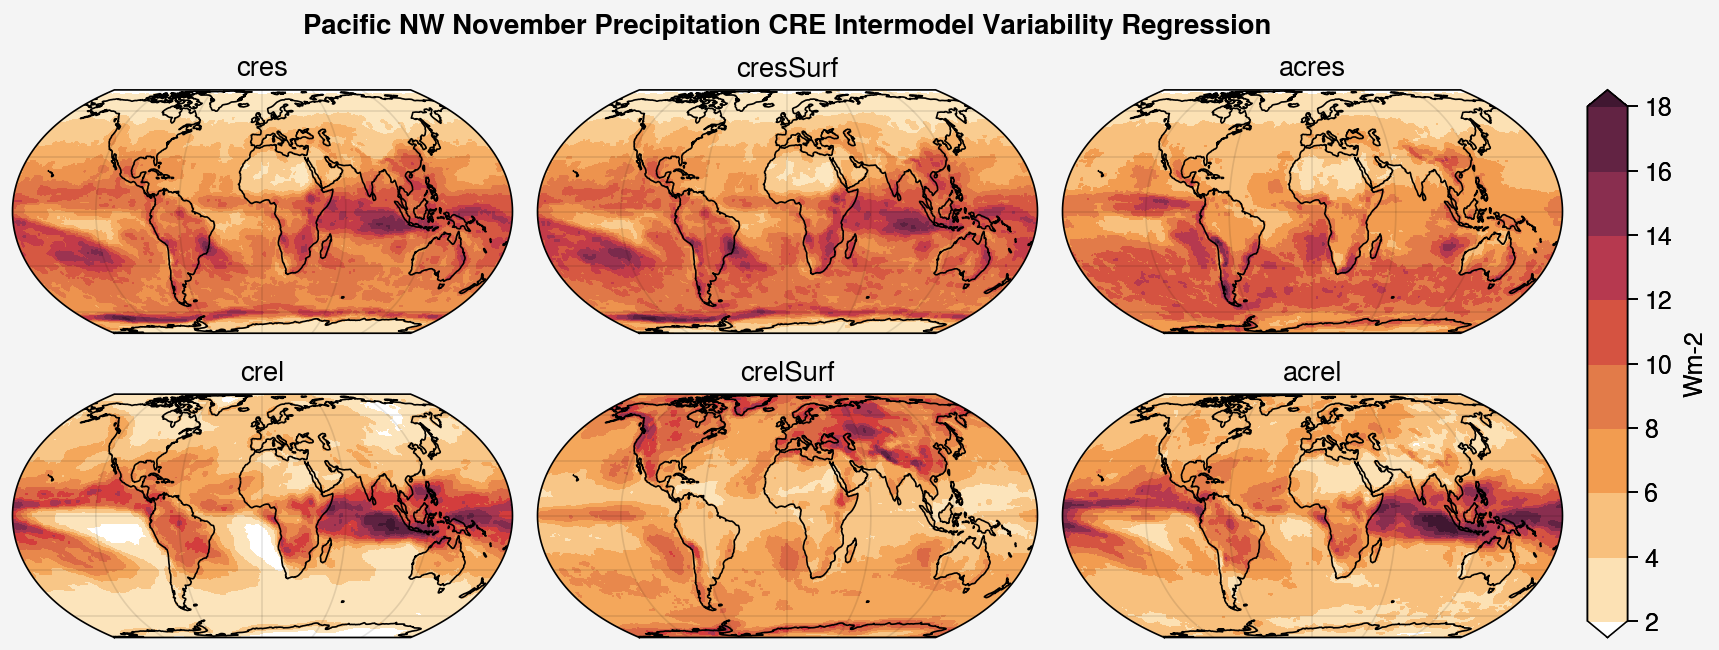

In [15]:
#Plotting the data
varList=['cres','cresSurf','acres','crel','crelSurf','acrel']
regressions=np.stack((cresregression,cresSurfregression,acresregression,crelregression,crelSurfregression,acrelregression))
fig,axes=pplt.subplots([[1,2,3],[4,5,6]],proj='eqearth')
for j,vname in enumerate(varList):
    con=axes[j].contourf(lon1,lat1,regressions[j],extend='both',colorbar_kw={'label': 'Wm-2'})
    axes[j].set_title(vname)
    
fig.format(coast=True)
axes.format(suptitle='Pacific NW November Precipitation CRE Intermodel Variability Regression')
cbar=plt.colorbar(con)
fig.save('PacificNW_Intermodel_Variability')